In [1]:
%load_ext autoreload
%autoreload 2

# device_num = 0

# !export CUDA_VISIBLE_DEVICES=device_num
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]=f"{device_num}"

#utf-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

In [51]:
import torch
print(torch.cuda.device_count())

from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, BitsAndBytesConfig
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from unsloth import FastLanguageModel
import pprint
import json
from pathlib import Path
import transformers
import os

# pca
from sklearn.decomposition import PCA
# tsne
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt


1


In [3]:
max_seq_length = 0     # Unsloth auto supports RoPE Scaling internally!
dtype = None              # None for auto detection
load_in_4bit = False      # Use 4bit quantization to reduce memory usage. Can be False.
device = f"cuda"



if torch.cuda.get_device_capability()[0] >= 8:
    attn_implementation = "flash_attention_2"
    torch_dtype = torch.bfloat16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float16
# attn_implementation = "eager"
print(f"Using {attn_implementation} for attention computation.")
# QLora?

Using flash_attention_2 for attention computation.


In [4]:
model_id = 'Bllossom/llama-3.2-Korean-Bllossom-3B'
model_dir = f"/model/{model_id.replace('/', '-')}"

In [5]:
# Tokenizer initialization
pretrained_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id,  
    # max_seq_length = max_seq_length,
    dtype = dtype,
    # load_in_4bit = False if not "27B" in model_id else True,
    # quantization_config=BitsAndBytesConfig(
    #     # load_in_4bit=True,
    #     # bnb_4bit_use_double_quant=True,
    #     # bnb_4bit_quant_type="nf4",
    #     # bnb_4bit_compute_dtype=torch_dtype
    #     load_in_8bit=False if not "27B" in model_id else True,
    #     llm_int8_enable_fp32_cpu_offload=False if not "27B" in model_id else True,
    # ),
    # device_map=device,
    cache_dir=f"{model_dir}/cache",
    attn_implementation=attn_implementation,
    # local_files_only=True
)

if not os.path.exists(model_dir):
    pretrained_model.save_pretrained(model_dir)

==((====))==  Unsloth 2025.2.5: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.413 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Bllossom/llama-3.2-Korean-Bllossom-3B does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


In [69]:
def get_embeddings(text):
    # Tokenize the input text
    encoding = tokenizer(text, return_tensors="pt")
    input_ids = encoding['input_ids'].to(pretrained_model.device)
    
    # Get model outputs without gradients
    with torch.no_grad():
        # For causal language models, we need to access the hidden states specifically
        outputs = pretrained_model(input_ids, output_hidden_states=True)
        
        # The hidden states are returned as a tuple of tensors, with the last element being the final layer
        # Get the last hidden state (embedding from the final layer)
        embeddings = outputs.hidden_states[-1]
    
    # Remove batch dimension [1, seq_len, hidden_dim] -> [seq_len, hidden_dim]
    embeddings = embeddings.squeeze(0)
    
    # Get the tokens for reference
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Print token and embedding shape info
    print(f"Input: '{text}'")
    print(f"Tokenized into {len(tokens)} tokens: {tokens}")
    print(f"Embedding shape: {embeddings.shape}")
    
    # Bfloat16 -> Float32
    embeddings = embeddings.float().cpu().numpy()
    
    # run dimension reduction
    embeddings_pca = PCA(n_components=2).fit_transform(embeddings)
    print(f"Reduced embedding shape: {embeddings_pca.shape}")
    
    embeddings_tsne = TSNE(n_components=2).fit_transform(embeddings)
    
    # Return both tokens and embeddings for easier analysis
    return tokens, embeddings, embeddings_pca, embeddings_tsne

def draw(tokens, embeddings_pca):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=80)
    ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
    for i, txt in enumerate(tokens):
        ax.annotate(txt, (embeddings_pca[i, 0], embeddings_pca[i, 1]))
    fig.tight_layout()
    plt.show()
    
def draw_1d(tokens, embeddings_pca):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=80)
    ax.scatter([0] * len(embeddings_pca), embeddings_pca)
    for i, txt in enumerate(tokens):
        ax.annotate(txt, (0, embeddings_pca[i]))
    fig.tight_layout()
    plt.show()

Input: 'Hi! My name is Bllossom. I am a Korean language model.'
Tokenized into 17 tokens: ['<|begin_of_text|>', 'Hi', '!', 'ĠMy', 'Ġname', 'Ġis', 'ĠBl', 'loss', 'om', '.', 'ĠI', 'Ġam', 'Ġa', 'ĠKorean', 'Ġlanguage', 'Ġmodel', '.']
Embedding shape: torch.Size([17, 3072])
Reduced embedding shape: (17, 2)


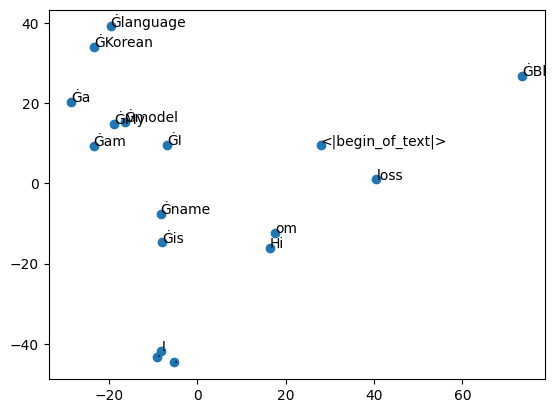

In [43]:
input_str = "Hi! My name is Bllossom. I am a Korean language model."
# input_str = "안녕하세요! 제 이름은 블로썸입니다. 저는 한국어 언어 모델입니다."
input_tokens, input_embeddings = get_embeddings(input_str)

In [71]:
input_str = \
"""Advancements in Sensor Data Analysis: Enhancing Decision-Making Across Industries

In recent years, the proliferation of sensor technologies has revolutionized data collection across various sectors, including healthcare, agriculture, and industrial automation. These sensors generate vast amounts of data, necessitating sophisticated analysis techniques to extract actionable insights. This paper explores the latest advancements in sensor data analysis and their applications in enhancing decision-making processes.

1. Introduction

Sensor data refers to the information collected by devices that detect and respond to environmental inputs such as temperature, motion, light, and chemical compositions. The integration of these sensors into systems enables real-time monitoring and control, leading to improved efficiency and safety. However, the sheer volume and complexity of sensor data present challenges in processing and interpretation.

"""
tokens, embeddings, embeddings_pca, embeddings_tsne = get_embeddings(input_str)



Input: 'Advancements in Sensor Data Analysis: Enhancing Decision-Making Across Industries

In recent years, the proliferation of sensor technologies has revolutionized data collection across various sectors, including healthcare, agriculture, and industrial automation. These sensors generate vast amounts of data, necessitating sophisticated analysis techniques to extract actionable insights. This paper explores the latest advancements in sensor data analysis and their applications in enhancing decision-making processes.

1. Introduction

Sensor data refers to the information collected by devices that detect and respond to environmental inputs such as temperature, motion, light, and chemical compositions. The integration of these sensors into systems enables real-time monitoring and control, leading to improved efficiency and safety. However, the sheer volume and complexity of sensor data present challenges in processing and interpretation.

'
Tokenized into 150 tokens: ['<|begin_of_tex

(150,)


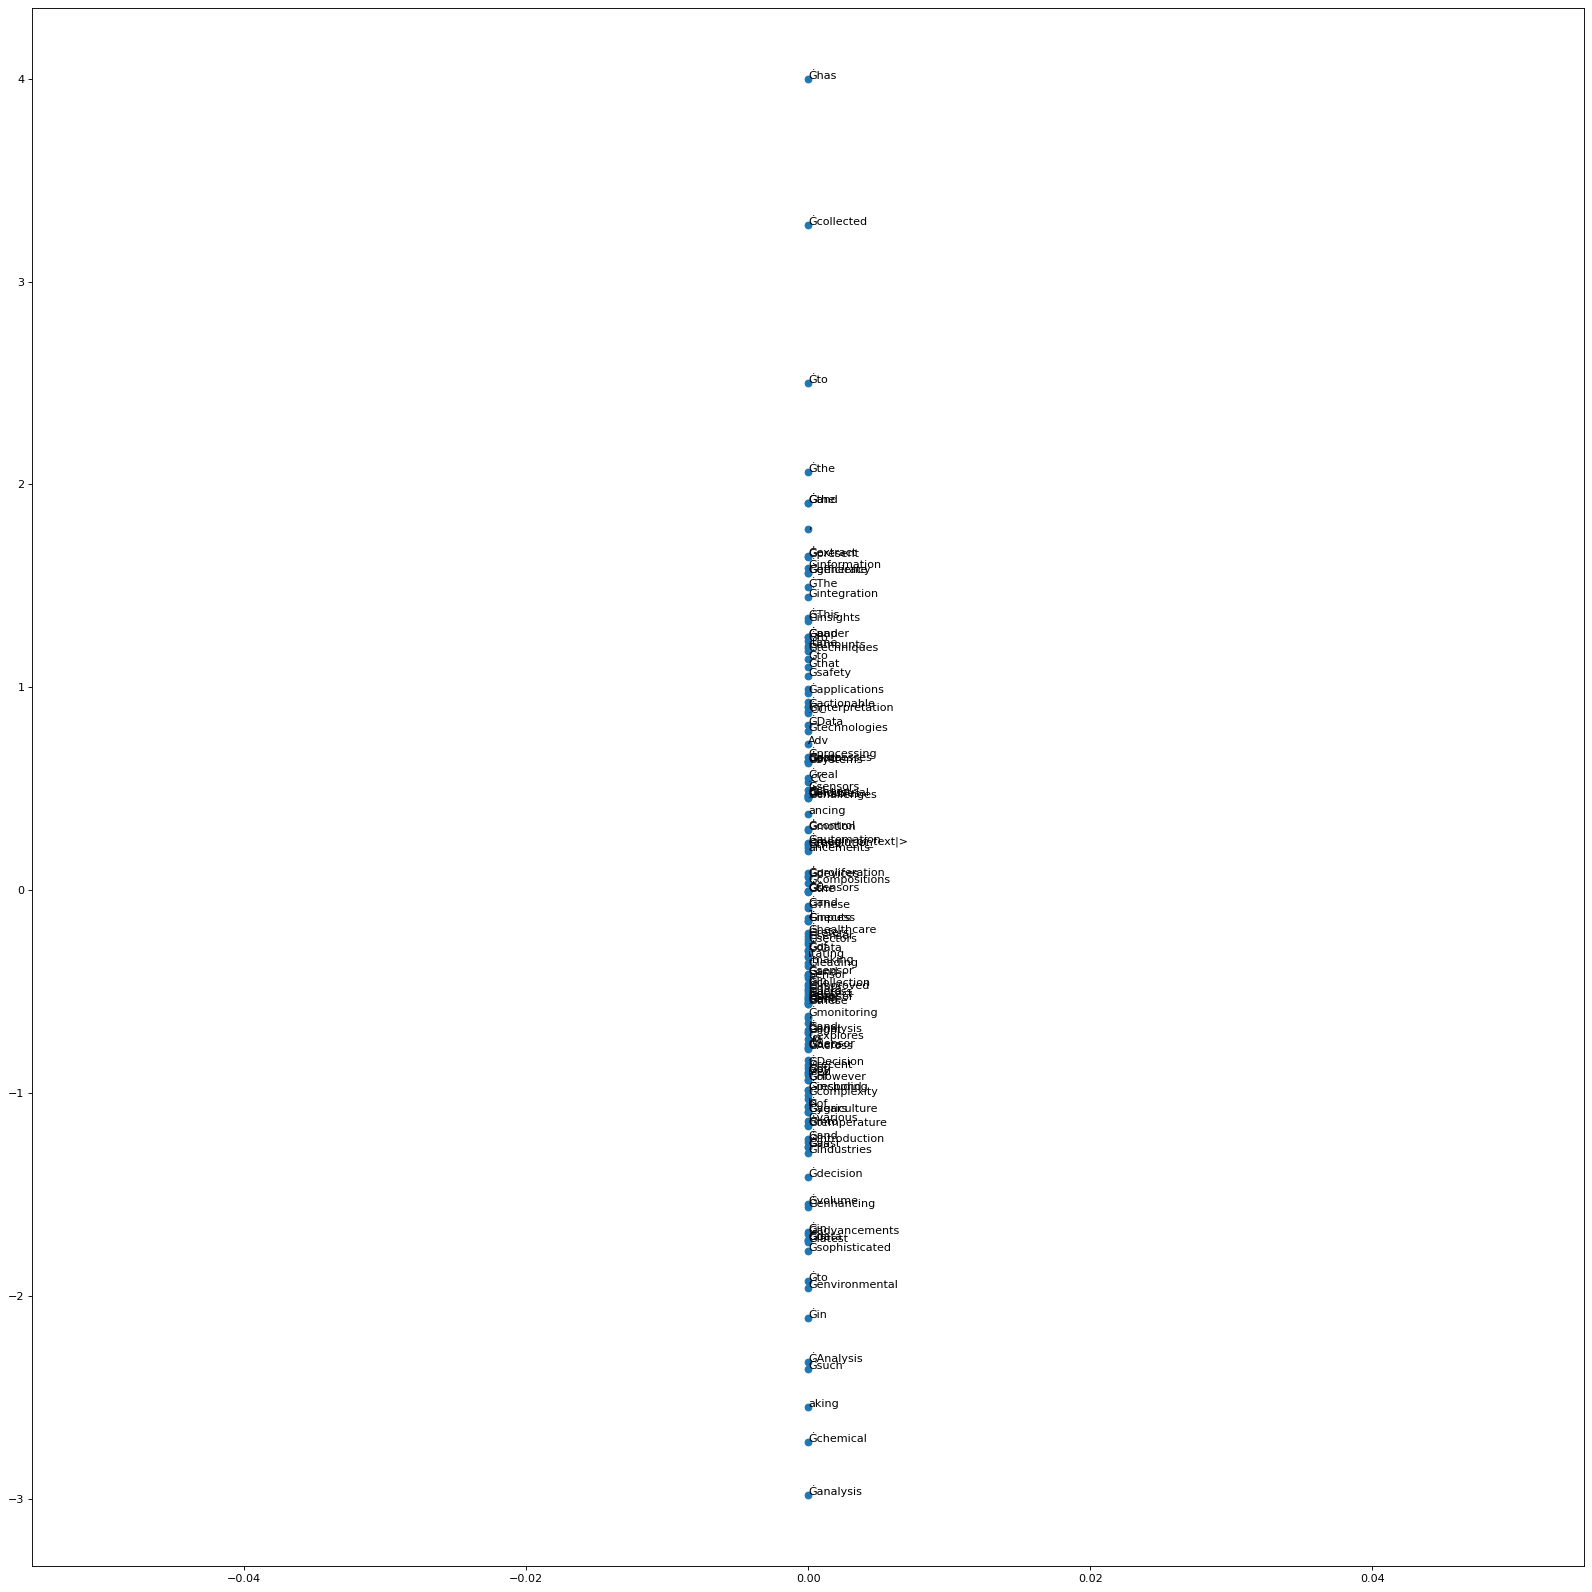

In [72]:
import itertools
# for (dim_0, dim_1) in itertools.combinations(range(embeddings.shape[1]), 2):
#     draw(tokens, embeddings[:, [dim_0, dim_1]])
#     break

for (dim_0) in range(embeddings.shape[1]):
    print(embeddings[:, dim_0].shape)
    draw_1d(tokens, embeddings[:, dim_0])
    

In [ ]:
input_str = "My"
get_embeddings(input_str)

2 1


['My']

In [ ]:
input_str = "name"
get_embeddings(input_str)

4 1


['name']